<div align="center">

# **Table of Contents**

</div>

* **[Introduction](#introduction)**

* **[Environment & Authentication](#environment--authentication)**

* **[Importing Necessary Libraries](#importing-necessary-libraries)**

* **[Data Loading](#data-loading)**

* **[Dataset Understanding & Quick EDA](#dataset-understanding--quick-eda)**
  * [Dataset Columns & Their Meanings](#dataset-columns--their-meanings)
  * [Sample Records](#sample-records)
  * [Minor EDA](#minor-eDA)

* **[Preprocessing](#preprocessing)**

* **[Load Tokenizer](#load-tokenizer)**

* **[Apply Preprocessing Function](#apply-preprocessing-function)**

* **[Dynamic Padding](#dynamic-padding)**

* **[Load the Model](#load-the-model)**

* **[Evaluation on Validation Set](#evaluation-on-validation-set)**
  * [Single-Case Analysis](#single-case-analysis)
  * [Comprehensive Validation Set Evaluation](#comprehensive-validation-set-evaluation)

* **[In-Context Learning (ICL)](#in-context-learning-icl)**
  * [Few-Shot ICL](#few-shot-icl)
  * [Zero-Shot Chain-of-Thought (CoT)](#zero-shot-chain-of-thought-cot)
  * [ICL Evaluation Table](#icl-evaluation-table)

* **[Fine-Tuning with LoRA](#fine-tuning-with-lora)**
  * [Prepare the Data](#prepare-the-data)
  * [Fine-Tuning the Model](#fine-tuning-the-model)
  * [Evaluate the Model](#evaluate-the-model)
  * [Compare the results](#compare-the-results)

* **[ICL on the Fine-Tuned Model](#icl-on-the-fine-tuned-model)**
  * [Load the fine-tuned LoRA model](#load-the-fine-tuned-loRA-model)
  * [Build the same few-shot prompt](#build-the-same-few-shot-prompt)
  * [Evaluate the New Model](#evaluate-the-new-model)
  * [Final Comparison](#final-comparison)

* **[Result Analysis & Discussion](#result-analysis--discussion)**

* **[Questions](#questions)**

## **Introduction**

This project explores how **large language models (LLMs)** handle multiple-choice commonsense reasoning using the **SWAG dataset** (113k scenarios with four candidate endings). Unlike simple classification, these tasks require context understanding and inference, making them a good testbed for foundation models.

Our goals are to:

* Build a **baseline** with pretrained **BERT (base-uncased)**.
* Experiment with **In-Context Learning (ICL)** techniques (few-shot & zero-shot CoT).
* Apply **LoRA fine-tuning** to adapt BERT efficiently on SWAG.
* Compare results across baseline, ICL, and fine-tuned models.

This will highlight when to rely on **ICL prompting** versus **parameter-efficient fine-tuning**, and how LLMs extend beyond traditional approaches in semantic tasks.

## **Environment & Authentication**

In [ ]:
# !pip install -q datasets transformers evaluate accelerate

from huggingface_hub import notebook_login
notebook_login()   # <-- paste your token when prompted


# Mount your drive:
# from google.colab import drive
# drive.mount('/content/drive')

## **Importing Necessary Libraries**

In [117]:
from datasets import load_dataset
from transformers import AutoModelForMultipleChoice
from datasets import load_from_disk
import pandas as pd
import matplotlib.pyplot as plt
from transformers import AutoTokenizer
from transformers import DataCollatorForMultipleChoice
import torch
from torch.utils.data import DataLoader
from transformers import DataCollatorForMultipleChoice
import math
from peft import LoraConfig, TaskType, get_peft_model
from transformers import TrainingArguments, Trainer
import numpy as np
from transformers.trainer_callback import EarlyStoppingCallback
from sklearn.metrics import confusion_matrix
import seaborn as sns
from peft import PeftModel
import evaluate

## **Data Loading**

In [ ]:
# Download the standard SWAG configuration ("regular")

# swag = load_dataset("swag", "regular")
# swag

In [ ]:
# save the dataset:

dataset_save_directory = "/content/drive/MyDrive/Colab Notebooks/swag_dataset_saved"
# swag.save_to_disk(dataset_save_directory)
# print(f"SWAG dataset saved to {dataset_save_directory}")

In [ ]:
# Load the dataset

swag = load_from_disk(dataset_save_directory)
print("Dataset loaded successfully!")
swag

Dataset loaded successfully!


DatasetDict({
    train: Dataset({
        features: ['video-id', 'fold-ind', 'startphrase', 'sent1', 'sent2', 'gold-source', 'ending0', 'ending1', 'ending2', 'ending3', 'label'],
        num_rows: 73546
    })
    validation: Dataset({
        features: ['video-id', 'fold-ind', 'startphrase', 'sent1', 'sent2', 'gold-source', 'ending0', 'ending1', 'ending2', 'ending3', 'label'],
        num_rows: 20006
    })
    test: Dataset({
        features: ['video-id', 'fold-ind', 'startphrase', 'sent1', 'sent2', 'gold-source', 'ending0', 'ending1', 'ending2', 'ending3', 'label'],
        num_rows: 20005
    })
})

## **Dataset Understanding & Quick EDA**

### Dataset Columns & Their Meanings

Based on the SWAG dataset documentation, here is what each field represents:

* **`video-id`** → Identifier for the original video clip (SWAG was built from video captions).
* **`fold-ind`** → Index used in the original paper for cross-validation folds.
* **`startphrase`** → Starting fragment of the sentence (largely superseded by `sent1` and `sent2`).
* **`sent1`** → The **context sentence**, describing the initial situation.
* **`sent2`** → The **continuation fragment**, leading to the missing ending.
* **`gold-source`** → Indicates if the correct ending is from the gold dataset or generated as a distractor.
* **`ending0..3`** → Four candidate endings. Only one is correct.
* **`label`** → Integer (0–3) pointing to the correct ending.

**Key columns for modeling**: `sent1`, `sent2`, `ending0..3`, `label`.
The rest are metadata and can be ignored later.

### Sample Records

In [ ]:
for i in range(2):
    ex = swag["validation"][i]
    print(f"Context: {ex['sent1']} {ex['sent2']}")
    for j in range(4):
        print(f"  Option {j}: {ex[f'ending{j}']}")
    print(f"Correct label: {ex['label']}\n")

Context: Students lower their eyes nervously. She
  Option 0: pats her shoulder, then saunters toward someone.
  Option 1: turns with two students.
  Option 2: walks slowly towards someone.
  Option 3: wheels around as her dog thunders out.
Correct label: 2

Context: He rides the motorcycle down the hall and into the elevator. He
  Option 0: looks at a mirror in the mirror as he watches someone walk through a door.
  Option 1: stops, listening to a cup of coffee with the seated woman, who's standing.
  Option 2: exits the building and rides the motorcycle into a casino where he performs several tricks as people watch.
  Option 3: pulls the bag out of his pocket and hands it to someone's grandma.
Correct label: 2



Each record gives us a short context (`sent1` + `sent2`) followed by four candidate endings (`ending0–3`). Only one is correct, and the correct choice is indicated by the integer in `label`:.

### Minor EDA

#### Class balance

Expect roughly **25% per class**, since the dataset is balanced across options.

In [ ]:
df_val = swag["validation"].to_pandas()
df_val["label"].value_counts(normalize=True)

,proportion
label,
2,0.251824
1,0.251375
3,0.250225
0,0.246576


#### Sentence lengths

In [ ]:
length_stats = {
    "sent1": df_val["sent1"].str.split().apply(len).describe(),
    "sent2": df_val["sent2"].str.split().apply(len).describe(),
    "ending0": df_val["ending0"].str.split().apply(len).describe(),
    "ending1": df_val["ending1"].str.split().apply(len).describe(),
    "ending2": df_val["ending2"].str.split().apply(len).describe(),
    "ending3": df_val["ending3"].str.split().apply(len).describe()
}

pd.DataFrame(length_stats)

,sent1,sent2,ending0,ending1,ending2,ending3
count,20006.000000,20006.000000,20006.000000,20006.000000,20006.000000,20006.000000
mean,11.809257,2.751924,8.869589,8.866890,8.839298,8.867290
std,5.513538,3.186542,4.097382,4.099503,4.052248,4.074749
min,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,8.000000,1.000000,6.000000,6.000000,6.000000,6.000000
50%,11.000000,2.000000,8.000000,8.000000,8.000000,8.000000
75%,15.000000,3.000000,11.000000,11.000000,11.000000,11.000000
max,67.000000,46.000000,25.000000,25.000000,25.000000,25.000000


#### Gold-Source Distribution

* Gold endings = real, correct human-written continuations.
* Adversarial endings = machine-generated, plausible-sounding but incorrect continuations.

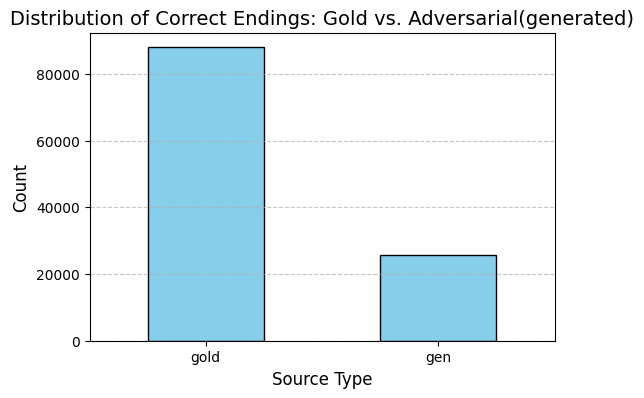

gold: 77.44%
gen: 22.56%


In [ ]:
correct_sources = []
for split in ["train", "validation", "test"]:
    correct_sources.extend(swag[split]["gold-source"])

source_count = pd.Series(correct_sources).value_counts()

plt.figure(figsize=(6,4))
source_count.plot(kind='bar', color='skyblue', edgecolor='black')

plt.title("Distribution of Correct Endings: Gold vs. Adversarial(generated)", fontsize=14)
plt.xlabel("Source Type", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()

source_pct = (source_count / source_count.sum() * 100).round(2)
for src, pct in source_pct.items():
    print(f"{src}: {pct}%")

## **Preprocessing**

We’ll convert each SWAG example into **four paired inputs** (one per choice) in the format expected by multiple-choice transformers (e.g., BERT). The idea:

1. **Build the context** once per example: `context = sent1 + " " + sent2`
2. **Replicate** that context 4× (one for each ending).
3. **Pair** the replicated context with each ending (`ending0..3`) → 4 (context, ending) pairs.
4. **Flatten** all pairs in a batch, **tokenize** with a Hugging Face tokenizer (no padding here).
5. **Unflatten** back to shape `(batch_size, 4, seq_len)` so the Trainer/Collator understands the 4 choices.

> We keep **padding=False** here (dynamic padding will be handled later by `DataCollatorForMultipleChoice`).


In [91]:
def preprocess_swag_batch(
    examples: dict,
    tokenizer,
    max_length: int = 256,
    num_choices: int = 4,
):
    """
    1. Replicate sent1 four times per example.
    2. Append sent2 to complete the setup.
    3. Concatenate each result with one of the four endings.
    4. Flatten and tokenize.
    5. Unflatten so each example keeps its list of four encodings.
    """

    batch_size = len(examples["sent1"])

    # 1-3
    flat_inputs = []
    for i in range(batch_size):
        prefix = f"{examples['sent1'][i]} {examples['sent2'][i]}"
        flat_inputs.extend(
            f"{prefix} {examples[f'ending{j}'][i]}" for j in range(num_choices)
        )

    # 4
    tokenized = tokenizer(
        flat_inputs,
        truncation=True,
        max_length=max_length,
        padding=False,          # let DataCollator handle dynamic padding
        return_attention_mask=True,
    )

    # 5
    def regroup(lst):
        return [lst[i * num_choices : (i + 1) * num_choices] for i in range(batch_size)]

    features = {k: regroup(v) for k, v in tokenized.items()}

    if "label" in examples:
        features["labels"] = examples["label"]

    return features

## **Load Tokenizer**


We use the **BERT Base Uncased tokenizer** from Hugging Face.
The tokenizer converts raw text pairs (context + ending) into **token IDs, attention masks, and token type IDs** — the exact format expected by BERT models.


* **`bert-base-uncased`** → lowercase English vocabulary, widely used as a baseline.


In [92]:
tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-uncased")

## **Apply Preprocessing Function**

Now that we have our preprocessing function, we apply it to the full SWAG dataset.  
We use the `map` method with `batched=True` so multiple rows are processed at once, which speeds things up.  
We also remove unused columns (metadata) to keep the dataset clean.


In [93]:
columns_to_remove = [
    "video-id","fold-ind","startphrase","sent1","sent2",
    "gold-source","ending0","ending1","ending2","ending3","label"
]

encoded_swag = swag.map(
    lambda batch: preprocess_swag_batch(batch, tokenizer),
    batched=True,
    remove_columns=swag["train"].column_names,
)

encoded_swag

Map:   0%|          | 0/73546 [00:00<?, ? examples/s]

Map:   0%|          | 0/20006 [00:00<?, ? examples/s]

Map:   0%|          | 0/20005 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 73546
    })
    validation: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 20006
    })
    test: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 20005
    })
})

## **Dynamic Padding**

We will use `DataCollatorForMultipleChoice` so each batch is padded **only** to the longest sequence in that batch (saves memory/compute). It also handles the flatten → pad → unflatten logic for MCQs.

In [94]:
mcq_collator = DataCollatorForMultipleChoice(
    tokenizer=tokenizer,
    padding=True
)

## **Load the Model**

We use **BERT Base Uncased** with a multiple-choice classification head. This architecture is designed so that for each example, the model receives 4 input sequences (context + ending) and outputs a score for each option. The option with the highest score is the model’s prediction.

In [95]:
# # Download the model
# model = AutoModelForMultipleChoice.from_pretrained("google-bert/bert-base-uncased")

In [96]:
# # Save the model
model_save_directory = "/content/drive/MyDrive/Colab Notebooks/my_saved_model"
# model.save_pretrained(model_save_directory)
# print(f"Model saved to {model_save_directory}")

In [97]:
# Load the model
model = AutoModelForMultipleChoice.from_pretrained(model_save_directory)
print("Model loaded successfully!")

Model loaded successfully!


## **Evaluation on Validation Set**

In this step, we evaluate the pretrained BERT model on the SWAG validation split. We perform two levels of analysis:
1. **Single-Case Analysis** — inspect one validation example end-to-end.
2. **Comprehensive Validation Set Evaluation** — run through the split and compute accuracy.

### Single-Case Analysis

To better understand how the model behaves, we select one validation example and inspect:

* The given context (sent1 + sent2)
* The four candidate endings
* The model’s predicted answer vs. the gold label
* The probability distribution across the four options

In [98]:
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

idx = 7  # you can change this to any index
raw = swag["validation"][idx]

print("Context:")
print(raw["sent1"], raw["sent2"], "\n")
for j in range(4):
    print(f"Option {j}: {raw[f'ending{j}']}")
print("\nGold label:", raw["label"])

collator = DataCollatorForMultipleChoice(tokenizer=tokenizer, padding=True)
one_item = encoded_swag["validation"].select([idx])
dl = DataLoader(one_item, batch_size=1, shuffle=False, collate_fn=collator)

batch = next(iter(dl))
batch = {k: v.to(device) for k, v in batch.items()}

with torch.no_grad():
    outputs = model(
        input_ids=batch["input_ids"],
        attention_mask=batch["attention_mask"],
        token_type_ids=batch.get("token_type_ids"),
    )
    logits = outputs.logits

probs = torch.softmax(logits, dim=-1).squeeze(0).cpu().tolist()
pred = int(torch.argmax(logits, dim=-1).item())

print("\nModel Prediction:", pred)
for j, p in enumerate(probs):
    print(f"  P(option {j}) = {p:.3f}")

print("\nCorrect?" , "Yes" if pred == raw["label"] else "No")

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Context:
A man is shown speaking to the camera and holding up various tools and products. He 

Option 0: continues cutting the pieces all around the roof and presenting it to the camera.
Option 1: continues putting the sandwich into the bike and shows how to use it.
Option 2: begins taking off a bike's handlebars and moving them around.
Option 3: continues scraping the hair while looking directly into the camera.

Gold label: 2

Model Prediction: 0
  P(option 0) = 0.255
  P(option 1) = 0.251
  P(option 2) = 0.251
  P(option 3) = 0.243

Correct? No


The probabilities are very close across options (0.22–0.26), showing that the model is largely uncertain and close to random guessing. Its choice of option 0 over the correct option 2 suggests that the model relies more on surface plausibility than deeper contextual reasoning.

### Comprehensive Validation Set Evaluation

Next, we evaluate the model on the **entire validation split**. We process all 20,006 examples in batches and compute the **overall accuracy**:

$$
\text{Accuracy} = \frac{\text{Number of correct predictions}}{\text{Total examples}}
$$

This serves as our **baseline score** for pretrained BERT, before introducing In-Context Learning (ICL) or fine-tuning.


In [100]:
metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    return metric.compute(predictions=preds, references=labels)

eval_args = TrainingArguments(
    output_dir="./eval_tmp",
    do_train=False,
    per_device_eval_batch_size=32,
    fp16=True,
    report_to="none",
)

trainer = Trainer(
    model=model,
    args=eval_args,
    eval_dataset=encoded_swag["validation"],
    data_collator=mcq_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

baseline_accuracy = trainer.evaluate()
print(f"Validation accuracy: {baseline_accuracy['eval_accuracy']:.4f}")


/tmp/ipython-input-181418050.py:16: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Validation accuracy: 0.3123


This baseline confirms that pretrained BERT performs better than chance (25%), but still lacks strong commonsense reasoning.

## **In-Context Learning (ICL)**

Below is a clean, modular ICL setup with shared helpers and minimal repetition.

In [114]:
# --- Shared formatting utilities ---

def format_example_for_prompt(ex):
    ctx = f"{ex['sent1']} {ex['sent2']}"
    opts = "\n".join([f"Option {i}: {ex[f'ending{i}']}" for i in range(4)])
    return f"Context: {ctx}\n{opts}\n"

def build_fewshot_prompt(train_ds, shot_ids):
    parts = ["You are answering multiple-choice questions about everyday scenarios.\n"
             "Choose the most plausible ending.\n\n"]
    for i in shot_ids:
        ex = train_ds[i]
        parts.append(format_example_for_prompt(ex) + f"Correct Answer: {ex['label']}\n\n")
    parts.append("Now answer this:\n")
    return "".join(parts)

def build_cot_prompt():
    return ("Think step by step about which option best continues the context.\n"
            "Pick the most plausible ending.\n")


# --- Generic preprocessing with an arbitrary prompt ---

def preprocess_with_prompt(examples, tokenizer, prompt, max_length=256, num_choices=4):
    first, second = [], []
    endings = list(zip(*[examples[f"ending{i}"] for i in range(num_choices)]))
    for s1, s2, ends in zip(examples["sent1"], examples["sent2"], endings):
        first.extend([s1] * num_choices)
        second.extend([prompt + s2 + e for e in ends])

    tok = tokenizer(first, second, truncation=True, max_length=max_length,
                    padding=False, return_attention_mask=True)

    def unflat(x): return [x[i:i+num_choices] for i in range(0, len(x), num_choices)]
    feats = {k: unflat(v) for k, v in tok.items()}
    if "label" in examples: feats["labels"] = examples["label"]
    return feats


# --- Lightweight evaluator ---

def evaluate_mcq_dataset(encoded_ds, model, tokenizer, batch_size=32):
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    collator = DataCollatorForMultipleChoice(tokenizer=tokenizer, padding=True)
    loader = DataLoader(encoded_ds, batch_size=batch_size, shuffle=False, collate_fn=collator)

    correct = total = 0
    with torch.no_grad():
        for batch in loader:
            labels = batch["labels"].to(device)
            batch = {k: v.to(device) for k, v in batch.items() if k != "labels"}
            logits = model(**batch).logits
            preds = logits.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return correct / total, correct, total


### Few-Shot ICL

We prepend a few solved examples (from training set) to the prompt before asking the model to answer a new question. This gives the model direct guidance.

In [ ]:
shot_ids = [0, 1]  # 2-shot
fewshot_prompt = build_fewshot_prompt(swag["train"], shot_ids)

encoded_val_fewshot = swag["validation"].map(
    lambda b: preprocess_with_prompt(b, tokenizer, fewshot_prompt, max_length=256),
    batched=True, remove_columns=columns_to_remove
)

acc_fewshot, c_fs, n_fs = evaluate_mcq_dataset(encoded_val_fewshot, model, tokenizer, batch_size=16)
print(f"Few-Shot ICL accuracy: {acc_fewshot:.4f} ({c_fs}/{n_fs})")

Map:   0%|          | 0/20006 [00:00<?, ? examples/s]

Few-Shot ICL accuracy: 0.3665 (7333/20006)


### Zero-Shot Chain-of-Thought (CoT)

Instead of solved examples, we ask the model to “think step by step” before deciding, encouraging reasoning.

In [ ]:
cot_prompt = build_cot_prompt()

encoded_val_cot = swag["validation"].map(
    lambda b: preprocess_with_prompt(b, tokenizer, cot_prompt, max_length=256),
    batched=True, remove_columns=columns_to_remove
)

acc_cot, c_cot, n_cot = evaluate_mcq_dataset(encoded_val_cot, model, tokenizer, batch_size=16)
print(f"Zero-Shot CoT ICL accuracy: {acc_cot:.4f} ({c_cot}/{n_cot})")

Map:   0%|          | 0/20006 [00:00<?, ? examples/s]

Zero-Shot CoT ICL accuracy: 0.3591 (7185/20006)


### ICL Evaluation Table

In [ ]:
import pandas as pd
results = pd.DataFrame({
    "Method": ["Baseline BERT (no ICL)", "Few-Shot ICL (2-shot)", "Zero-Shot CoT ICL"],
    "Validation Accuracy": [baseline_accuracy, acc_fewshot, acc_cot]
})
results

,Method,Validation Accuracy
0,Baseline BERT (no ICL),0.312306
1,Few-Shot ICL (2-shot),0.366540
2,Zero-Shot CoT ICL,0.359142


Both Few-Shot and Zero-Shot CoT ICL show an improvement over the baseline, indicating that in-context learning helps the pretrained BERT model perform better on this commonsense reasoning task.

## **Fine-Tuning with LoRA**

### Prepare the Data

In [106]:
train_ds = encoded_swag["train"]
val_ds   = encoded_swag["validation"]

mcq_collator = DataCollatorForMultipleChoice(tokenizer=tokenizer, padding=True)
len(train_ds), len(val_ds)

(73546, 20006)

### Fine-Tuning the Model

In [108]:
# LoRA config + wrap model

model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

lora_cfg = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    r=16,
    lora_alpha=32,
    lora_dropout=0.05,
    target_modules=["query", "value"],
    bias="none",
)

lora_model = get_peft_model(model, lora_cfg)
lora_model.print_trainable_parameters()

trainable params: 590,593 || all params: 110,073,602 || trainable%: 0.5365


In [109]:
acc_metric = evaluate.load("accuracy")
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    return acc_metric.compute(predictions=preds, references=labels)

train_args = TrainingArguments(
    output_dir="./swag-lora-final",
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    learning_rate=5e-5,
    lr_scheduler_type="linear",
    warmup_steps=230,
    weight_decay=0.01,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    gradient_accumulation_steps=4,
    num_train_epochs=5,
    fp16=True,
    seed=42,
    report_to="none",
)

trainer = Trainer(
    model=lora_model,
    args=train_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    data_collator=mcq_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],
)

trainer.train()
best_scores = trainer.evaluate()
print(f"🔹 final val accuracy = {best_scores['eval_accuracy']:.4f}")

/tmp/ipython-input-602083382.py:28: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.933400,0.712989,0.724433
2,0.866200,0.663084,0.743377
3,0.835100,0.638732,0.754174
4,0.811200,0.622922,0.758173
5,0.817900,0.621989,0.759572


🔹 final val accuracy = 0.7596


In [110]:
# Save the trained LoRA model
lora_model_save_directory = "/content/drive/MyDrive/Colab Notebooks/bert-swag-lora-accurate"
lora_model.save_pretrained(lora_model_save_directory)
print(f"Trained LoRA model saved to {lora_model_save_directory}")

Trained LoRA model saved to /content/drive/MyDrive/Colab Notebooks/bert-swag-lora-accurate


### Evaluate the Model

Validation Accuracy: 0.7596
Validation Loss:     0.6220
Validation Perplexity (exp(loss)): 1.8626


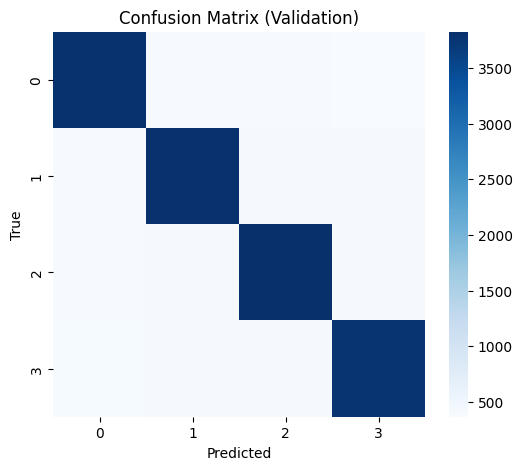

In [112]:
# Accuracy & Perplexity
eval_metrics = trainer.evaluate(val_ds)
eval_acc  = eval_metrics.get("eval_accuracy", None)
eval_loss = eval_metrics.get("eval_loss", None)
eval_ppl  = math.exp(eval_loss) if eval_loss is not None else None

print(f"Validation Accuracy: {eval_acc:.4f}")
print(f"Validation Loss:     {eval_loss:.4f}")
print(f"Validation Perplexity (exp(loss)): {eval_ppl:.4f}")


# Confusion Matrix
val_preds = trainer.predict(val_ds)

y_true = val_preds.label_ids
y_pred = val_preds.predictions.argmax(axis=-1)

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=False, cmap="Blues", cbar=True)
plt.title("Confusion Matrix (Validation)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

### Compare the results

| Approach                 | Validation Accuracy |
| ------------------------ | ------------------- |
| Baseline BERT (no ICL)   | **0.312**           |
| Few-Shot ICL (2-shot)    | **0.367**           |
| Zero-Shot CoT ICL        | **0.359**           |
| **LoRA Fine-Tuned BERT** | **0.760**           |


Fine-tuning with LoRA lifts accuracy by `≈ +44 percentage points` over the Baseline model and `≈ +39 pp` over the best pure-ICL run. Prompting alone helps, but weight updates dominate, once adequate task data and training time are available.

## **ICL on the Fine-Tuned Model**

### Load the fine-tuned LoRA model

In [ ]:
lora_model = PeftModel.from_pretrained(model, lora_model_save_directory)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lora_model.to(device).eval()

### Build the same few-shot prompt

In [115]:
shot_ids = [0, 1]
fewshot_prompt = build_fewshot_prompt(swag["train"], shot_ids)

encoded_val_finetuned_fewshot = swag["validation"].map(
    lambda b: preprocess_with_prompt(b, tokenizer, fewshot_prompt, max_length=320),
    batched=True,
    remove_columns=columns_to_remove
)

Map:   0%|          | 0/20006 [00:00<?, ? examples/s]

  ### Evaluate the New Model

In [116]:
acc_ft_icl, c_ft, n_ft = evaluate_mcq_dataset(
    encoded_val_finetuned_fewshot,
    lora_model,
    tokenizer,
    batch_size=16,
)
print(f"Fine-Tuned + Few-Shot ICL accuracy: {acc_ft_icl:.4f} ({c_ft}/{n_ft})")

Fine-Tuned + Few-Shot ICL accuracy: 0.5307 (10618/20006)


### Final Comparison

| Approach                          | Validation Accuracy |
| --------------------------------- | ------------------- |
| Baseline BERT (no ICL)            | **0.312**           |
| Few-Shot ICL (2-shot, pretrained) | **0.367**           |
| Zero-Shot CoT ICL (pretrained)    | **0.359**           |
| **LoRA Fine-Tuned BERT**          | **0.760**           |
| Fine-Tuned BERT + Few-Shot ICL    | **0.531**           |

Adding the same 2-shot prompt **hurts** the already fine-tuned model (-23 pp).

## **Result Analysis & Discussion**

We tested three main approaches: **In-Context Learning (ICL)** with the pretrained model, **LoRA fine-tuning**, and **Fine-Tuning + ICL**.

 1. Best Performing Method
    * The **fine-tuned LoRA model** achieved the highest accuracy (**\~76%**).
    * This shows that directly adapting BERT’s weights to the SWAG dataset is far more effective than relying on prompting alone.

 2. Effect of ICL on the Fine-Tuned Model
    * When we added **Few-Shot ICL** to the fine-tuned model, performance **dropped to \~53%**.
    * This suggests that once the model is already specialized for the task, extra prompt examples can:

        * Cause **input truncation** (longer sequences exceed the max length).
        * Introduce **conflicting signals**, distracting the model from its learned task-specific representations.

 3. When ICL Works Best

    * With the **pretrained (unmodified) BERT**, ICL gave small improvements (31% → 36%).
    * This makes sense because ICL helps guide a general model when no task-specific fine-tuning is available.

 4. Real-World Use Cases

    * **Fine-Tuning** is best for stable tasks with enough labeled data (e.g., legal document classification, medical report analysis).
    * **ICL** is useful for quick adaptation to new or low-data tasks (e.g., ad-hoc Q\&A, small business analytics).
    * **Combining both** may work in cases where the base model is fine-tuned broadly (e.g., medical domain), but ICL is used for **rare, sub-domain tasks** (e.g., diagnosing rare diseases with just a few examples).


> **In Conclusion**  
For SWAG, **fine-tuning alone is clearly superior**. ICL helps a general model but can reduce performance once the model has already been fine-tuned to the dataset.


## **Questions**

> ### **Fine-tuning vs. ICL vs. Both**

* Use **fine-tuning** when you have **enough labeled data**, the task is **stable**, you want **higher accuracy**, and you can **train on a GPU**. It makes inference **fast** (no long prompts).
* Use **ICL (prompting)** when you have **very few examples**, need something **working today**, **can’t/shouldn’t retrain**, or the task **changes often**.
* Use **both** when you **fine-tune for the core job** and add a **few prompt examples** to handle **new edge cases**, **user preferences**, or **small domain shifts** without running training again.

> ### **Designing Effective ICL Prompts for New Domains**

| Domain                         | What to Include in Shots                                                                                         | Design Tips                                                           |
| ------------------------------ | ---------------------------------------------------------------------------------------------------------------- | --------------------------------------------------------------------- |
| **Medical diagnosis**          | • Varied age, symptom clusters, severities <br>• Both common & rare conditions                                   | Keep notes concise; clarify diagnosis label; mirror clinical wording. |
| **Financial trend prediction** | • Bull & bear periods <br>• Key indicators (prices, volume, macro events) <br>• Short- and long-horizon examples | Use consistent numeric format; include dates; balance market regimes. |

**General factors when choosing prompt examples:**

* **Relevance & diversity:** cover the full range of real inputs.
* **Clarity:** minimal prose, clear label.
* **Representativeness:** match target data distribution.
* **Token budget:** 3–10 compact shots so the prompt fits `max_length`.
